# 第5章 误差反向传播算法（2020/02/18-） 

- 通过使用计算图，可以直观的把握计算过程。
- 计算图的节点是由局部计算构成的。局部计算构成全局计算。
- 计算图的正向传播进行一般的计算。通过计算图的反向传播，可以计算各个节点的导数。
- 通过将神经网络组成的元素实现为层，可以高效地计算梯度（反向传播法）。
- 通过比较数值微分和误差反向传播法的结果，可以确认误差反向传播法的实现是否正确。

通过数值微分计算神经网络权重参数的梯度虽然容易实现，但是计算上比较费时间，误差反向传播法可以高效地计算损失函数关于权重参数的梯度。

## 5.1-5.3 计算图、链式法则、反向传播 

 - 计算图采用的“从左向右进行计算”是一种正方向的传播，简称为正向传播
 - 计算图可以通过传递“局部计算”来获得最终结果，各节点只需进行与自己有关的计算
 
 - 反向传播将局部导数向正方向的反方向（从右到左）传递，传递局部导数的原理，是基于链式法则的
 - 加法节点的反向传播只乘1，所以输入的值会原封不动流向下一个节点
 - 乘法节点的反向传播会乘以正向传播时的输入信号的“翻转值”后传递给下游

## 5.4 简单层的实现 

这里的层是神经网络中功能的单位。比如，负责sigmoid函数的Sigmoid，负责矩阵乘积的Affine等，都是以层为单位的实现

层的实现中有两个共同的方法（接口）forward()和backward(),forward对应正向传播，backward对应反向传播

- 乘法层

In [1]:
# %load layer_naive.py


class MulLayer:
    def __init__(self):           #初始化两个实例变量x和y
        self.x = None
        self.y = None

    def forward(self, x, y):     
        self.x = x
        self.y = y                
        out = x * y

        return out

    def backward(self, dout):    #将从上游传来的导数乘以正向传播时的翻转值
        dx = dout * self.y
        dy = dout * self.x

        return dx, dy


class AddLayer:
    def __init__(self):
        pass

    def forward(self, x, y):
        out = x + y

        return out

    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1

        return dx, dy


In [2]:
pwd

'D:\\datasets\\Deep learning from scratch'

In [3]:
# 买苹果

apple = 100
apple_num = 2
tax = 1.1

#layer
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

#forward
apple_price = mul_apple_layer.forward(apple,apple_num)
price = mul_tax_layer.forward(apple_price,tax)

print(f"apple_price: {apple_price}")
print(f"price:{price}")

apple_price: 200
price:220.00000000000003


In [4]:
#backward 
dprice = 1
dapple_price,dtax = mul_tax_layer.backward(dprice)
dapple,dapple_num = mul_apple_layer.backward(dapple_price)

print(f"dapple_price = {dapple_price}, dtax = {dtax}")
print(f"dapple = {dapple}, dapple_num = {dapple_num}")

dapple_price = 1.1, dtax = 200
dapple = 2.2, dapple_num = 110.00000000000001


In [5]:
# %load buy_apple_orange.py
# from layer_naive import *

apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# layer
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)  # (1)
orange_price = mul_orange_layer.forward(orange, orange_num)  # (2)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)  # (3)
price = mul_tax_layer.forward(all_price, tax)  # (4)

# backward
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)  # (4)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)  # (3)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)  # (2)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)  # (1)

print("price:", int(price))
print("dApple:", dapple)
print("dApple_num:", int(dapple_num))
print("dOrange:", dorange)
print("dOrange_num:", int(dorange_num))
print("dTax:", dtax)

price: 715
dApple: 2.2
dApple_num: 110
dOrange: 3.3000000000000003
dOrange_num: 165
dTax: 650


## 5.5 激活函数层的实现 

In [6]:
# %load layers.py
import numpy as np
from common.functions import *
from common.util import im2col, col2im


class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx


class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx


class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 权重和偏置参数的导数
        self.dW = None
        self.db = None

    def forward(self, x):
        # 对应张量
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 还原输入数据的形状（对应张量）
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmax的输出
        self.t = None # 监督数据

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 监督数据是one-hot-vector的情况
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx


class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask


class BatchNormalization:
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # Conv层的情况下为4维，全连接层的情况下为2维  

        # 测试时使用的平均值和方差
        self.running_mean = running_mean
        self.running_var = running_var  
        
        # backward时使用的中间数据
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)
        
        return out.reshape(*self.input_shape)
            
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var            
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta 
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx


class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 中间数据（backward时使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 权重和偏置参数的梯度
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx


class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx


RELU层的作用就像电路中的开关一样。正向传播时，有电流通过的话，就将开关设为ON；没有电流通过的话，就将开关设为OFF。

反向传播时，开关为ON的话，电流会直接通过；开关为OFF的话，则不会有电流通过。

- Sigmoid层

In [7]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx

Sigmoid层的反向传播，只根据正向传播的输出就能计算出来。

In [8]:
# Affine/Softmax层的实现
class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 权重和偏置参数的导数
        self.dW = None
        self.db = None

    def forward(self, x):
        # 对应张量
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 还原输入数据的形状（对应张量）
        return dx

神经网络的正向传播中进行的矩阵乘积运算在几何学领域被称为“仿射变换”。因此，这里将进行仿射变换的处理实现为Affine层。

反向传播时，各数据的反向传播的值需要汇总为偏置的元素。

- Softmax-with-Loss层

In [9]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmax的输出
        self.t = None # 监督数据

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 监督数据是one-hot-vector的情况
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

softmax会将输入值正规化之后再输出。

神经网络中进行的处理有推理和学习两个阶段。神经网络的推理通常不使用softmax层，神经网络的学习阶段需要softmax层。

神经网络中未被正规化的输出结果又是被称为“得分”。

**反向传播的结果**

Softmax层的反向传播得到了$(y_1-t_1,y_2-t_2,y_3-t_3)$这样漂亮的结果，$(y_1-t_1,y_2-t_2,y_3-t_3)$是Softmax层的输出与监督标签的差分。神经网络的反向传播会把这个差分表示的误差传递给前面的层，这是神经网络学习中的重要性质。

## 5.7 误差反向传播法的实现 

神经网络中有合适的权重和偏置，调整权重和偏置以便拟合训练数据的过程称为学习。神经网络的学习分为以下4个步骤。

- step1: mini-batch 从训练数据中随机选择一部分数据
- step2: 计算梯度 计算损失函数关于各个权重参数的梯度
- step3: 更新参数 将权重参数沿梯度方向进行微小的更新
- step4: 重复步骤1、2、3

误差反向传播法会在步骤2中出现。

In [10]:
# %load two_layer_net.py
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
from common.functions import *
from common.gradient import numerical_gradient


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        #进行识别（推理）
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x:输入数据, t:监督数据
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:输入数据, t:监督数据
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

在确认误差反向传播算法是否正确时，是需要用到数值微分的。确认数值微分求出的梯度结果与误差反向传播算法求出的结果是否一致的操作称为**梯度确认**。 

In [13]:
# %load gradient_check.py
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
from mnist import load_mnist
from two_layer_net import TwoLayerNet

# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))

W1:2.0096590921814724e-10
b1:9.026121303959585e-10
W2:7.067581857116146e-08
b2:1.4177126500536374e-07


train acc, test acc | 0.10218333333333333, 0.101
train acc, test acc | 0.7846, 0.7928
train acc, test acc | 0.8741166666666667, 0.878
train acc, test acc | 0.8991, 0.8991
train acc, test acc | 0.9083166666666667, 0.9098
train acc, test acc | 0.9136333333333333, 0.9163
train acc, test acc | 0.91915, 0.9216
train acc, test acc | 0.9235333333333333, 0.9261
train acc, test acc | 0.9278333333333333, 0.9294
train acc, test acc | 0.9316666666666666, 0.9332
train acc, test acc | 0.9352166666666667, 0.9355
train acc, test acc | 0.9367166666666666, 0.9371
train acc, test acc | 0.9390666666666667, 0.9391
train acc, test acc | 0.9416833333333333, 0.9405
train acc, test acc | 0.94315, 0.9436
train acc, test acc | 0.94515, 0.946
train acc, test acc | 0.9469166666666666, 0.9474


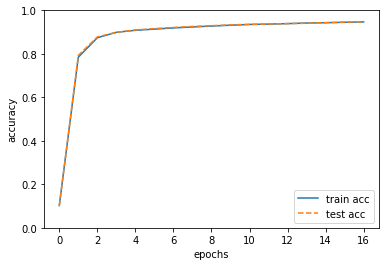

In [18]:
# %load train_neuralnet.py
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from two_layer_net import TwoLayerNet

# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000  # 适当设定循环的次数
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 计算梯度
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 更新参数
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 绘制图形
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()